In [1]:
from cheetah import Segment, ParticleBeam
import torch
import torch.nn as nn
import torch.nn.functional as F
import epics
import os
import numpy as np
import pprint
import h5py
from typing import List, Dict, Any, Callable
import yaml
import matplotlib.pyplot as plt
import math

In [2]:
def extract_group_contents(group, exclude_keys=None):
    """Safely extract datasets from a group, handling scalars and nested groups."""
    if exclude_keys is None:
        exclude_keys = set()
    data = {}
    for key in group:
        if key in exclude_keys:
            continue
        item = group[key]
        if isinstance(item, h5py.Dataset):
            data[key] = item[()] if item.shape == () else item[:]
        elif isinstance(item, h5py.Group):
            data[key] = extract_group_contents(item, exclude_keys)
    return data


images = {}
with h5py.File('../h5/tcav_calibration.h5', 'r') as f:
    image_root = f['images']
    exclude_keys = {'raw_images','processed_images','total_intensities', 'signal_to_noise_ratios'}

    for image_key in image_root:
        image_group = image_root[image_key]
        image_data = extract_group_contents(image_group, exclude_keys=exclude_keys)
        images[image_key] = image_data



In [3]:
# Since all the quad settings are matched in the simulated server and calibration file the only PVs we care about is tcav AREQ, PREQ
# Can extract these values from the group contents pretty easily
# We will also plot the average beam size x measurement versus phase

keys = [key for key in images.keys()]
centroid_stack = np.stack([
    np.nanmean(images[key]['centroids'],axis=0) for key in keys])
phase_stack = np.stack([
    images[key]['TCAV:DIAG0:11:PREQ'] for key in images])
phase_stack = phase_stack * (math.pi/180)
print(phase_stack)
print(centroid_stack)


[0.54663712 0.56655327 0.58542222 0.60481476 0.62473091 0.63836387
 0.65618562 0.67662537 0.69601791 0.71436326]
[[828.08930673 916.90077404]
 [818.34351269 915.30759782]
 [807.56969297 916.28401422]
 [793.69595668 915.02744222]
 [779.83461336 917.25265671]
 [769.61706806 917.46267198]
 [754.57756747 914.9925416 ]
 [739.4957848  912.41477866]
 [729.42872929 914.46341265]
 [718.79783602 913.04128056]]


In [4]:
from scipy.optimize import curve_fit
X= phase_stack
Y= centroid_stack
# 1. Linear fit for centroid X
def linear(x, m, b):
    return m * x + b

params_x, _ = curve_fit(linear, X, Y[:, 0])
fit_x = linear(X, *params_x)

# 2. Sine fit for centroid Y (still using degrees)
def sine_deg(x_deg, amplitude, phase_shift, frequency, offset):
    x_rad = np.radians(x_deg)
    return amplitude * np.sin(frequency * x_rad + phase_shift) + offset

p0_y = [np.ptp(Y[:, 1]) / 2, 0.0, 1.0, np.mean(Y[:, 1])]
params_y, _ = curve_fit(sine_deg, X, Y[:, 1], p0=p0_y)
fit_y = sine_deg(X, *params_y)

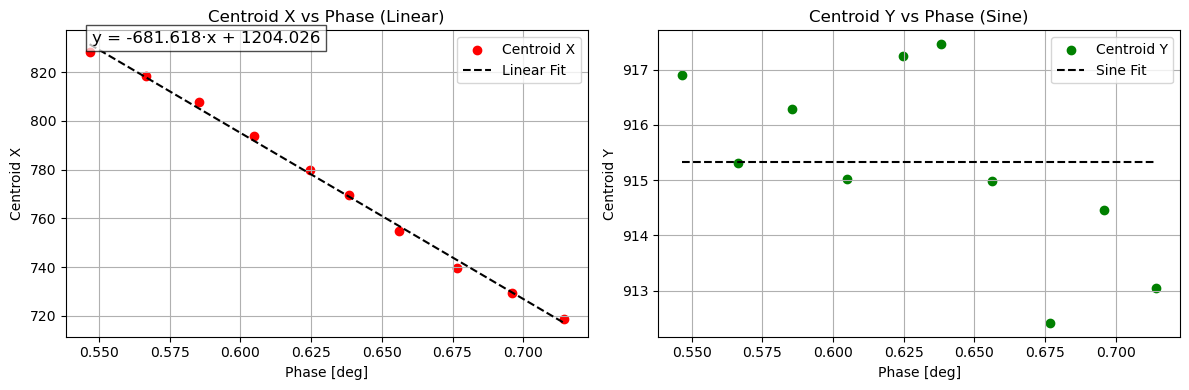

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Centroid X (Linear)
axes[0].scatter(X, Y[:, 0], color='red', label='Centroid X')
axes[0].plot(X, fit_x, color='black', linestyle='--', label='Linear Fit')
axes[0].set_title('Centroid X vs Phase (Linear)')
axes[0].set_xlabel('Phase [deg]')
axes[0].set_ylabel('Centroid X')
axes[0].legend()
axes[0].grid(True)
# Suppose params_x = [m, b]
eqn_x = f"y = {params_x[0]:.3f}·x + {params_x[1]:.3f}"
axes[0].text(0.05, 0.95, eqn_x, transform=axes[0].transAxes,
             fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.7))

# Centroid Y (Sine)
axes[1].scatter(X, Y[:, 1], color='green', label='Centroid Y')
axes[1].plot(X, fit_y, color='black', linestyle='--', label='Sine Fit')
axes[1].set_title('Centroid Y vs Phase (Sine)')
axes[1].set_xlabel('Phase [deg]')
axes[1].set_ylabel('Centroid Y')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [6]:
from lcls_tools.common.devices.reader import create_screen, create_tcav, create_magnet
from ml_tto.automatic_emittance.screen_profile import ScreenBeamProfileMeasurement
from ml_tto.automatic_emittance.image_projection_fit import RecursiveImageProjectionFit
from ml_tto.automatic_emittance.plotting import plot_image_projection_fit

In [7]:
def show_side_by_side(img1: np.ndarray, img2: np.ndarray, titles=('Original', 'Noisy'), cmap='hot'):
    """
    Plot two 2D images side-by-side as heat maps.

    Parameters:
        img1, img2 (np.ndarray): 2D arrays to plot.
        titles (tuple): Titles for the subplots.
        cmap (str): Colormap to use.
    """
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for ax, img, title in zip(axes, [img1, img2], titles):
        im = ax.imshow(img, cmap=cmap, origin='lower', aspect='auto')
        ax.set_title(title)
        ax.set_xlabel('X pixels')
        ax.set_ylabel('Y pixels')
        fig.colorbar(im, ax=ax, shrink=0.75, label='Intensity')
    plt.tight_layout()
    plt.show()

/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/epics/ca.py:1631: UserWarning: ca.get('OTRS:DIAG0:420:Image:ArrayData') timed out after 1.00 seconds.
  warnings.warn(msg % (name(chid), timeout))


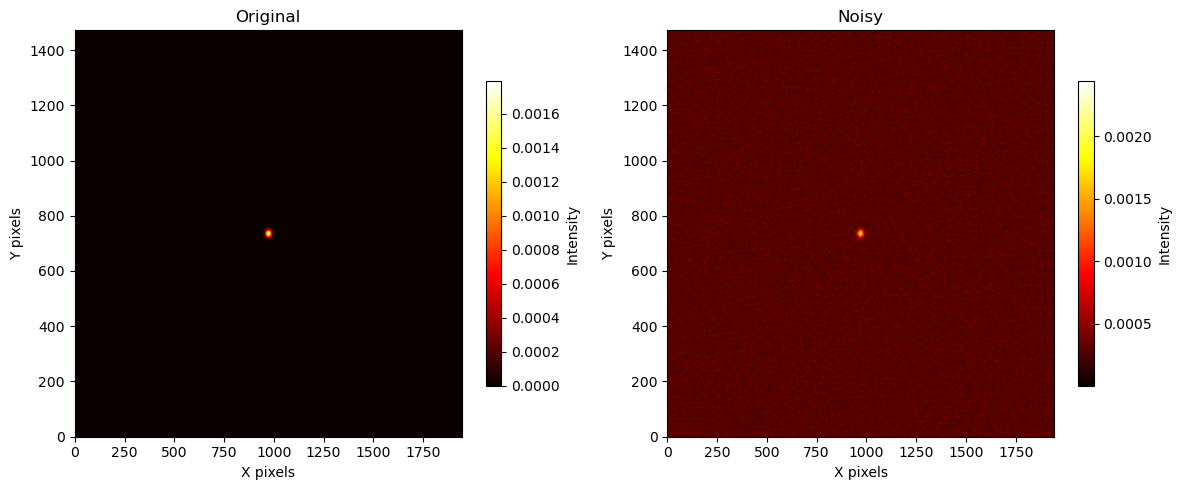

In [8]:
#Start server, track screen, fit beam get result, vary phase repeat for each phase in phase_stack, use lcls_tools library to control
# the screen, tcav, and magnets if needed
#TODO: fix tcav.phase_set not fucking working
screen = create_screen('DIAG0', 'OTRDG02')
#tcav = create_tcav('DIAG0', 'TCXDG0')

images = []
image =  screen.image 
noise_std = 0.2 * np.max(image)
image_noisey = image + np.abs(np.random.normal(loc=0, scale=noise_std, size=image.shape))
show_side_by_side(image,image_noisey)

i= 0
for phase in phase_stack:
    epics.caput('TCAV:DIAG0:11:PREQ', phase)
    image =  screen.image
    noise_std = 0.2 * (np.max(image) + .0001)
    #image += np.abs(np.random.normal(loc=0, scale= noise_std , size=image.shape))
    if i ==0:
        sneaky = image
    i+=1
    images.append(image)



In [9]:
#Fit images get centroids
#bad fits... eed to get centroids some other way
recImg = RecursiveImageProjectionFit(visualize=False)
sim_centroids = []
for image in images:
    result = recImg._fit_image(image)
    sim_centroids.append(result.centroid)
    #Dump images to file for training set.

sim_centroids_stack = np.stack([centroid for centroid in sim_centroids])
#plt.imshow(sneaky, cmap='hot', origin='lower', aspect='auto')

In [10]:

#TODO: figure out what the problem with the fits is? for now interpolate points and try and optimize with a few interpolated points
c = torch.tensor(sim_centroids)
c

tensor([[ 996.9916,  736.0286],
        [ 998.3101,  736.0284],
        [ 999.0312,  736.0275],
        [ 999.8002,  736.0267],
        [1000.6176,  736.0262],
        [1000.8654,  736.0278],
        [1001.9934,  736.0286],
        [1003.3587,  736.0285],
        [1004.1267,  736.0279],
        [1004.7979,  736.0267]], dtype=torch.float64)

In [11]:


def interpolate_nans(data):
    """
    Linearly interpolates missing values (np.nan) in a 1D NumPy array or PyTorch tensor.
    Extrapolates linearly at the ends if NaNs are present there.
    
    Parameters:
        data (np.ndarray or torch.Tensor): 1D array/tensor with NaNs.

    Returns:
        torch.Tensor: 1D tensor with NaNs filled.
    """
    # Convert to NumPy array if torch tensor
    is_tensor = isinstance(data, torch.Tensor)
    arr = data.numpy() if is_tensor else np.array(data, dtype=float)

    x = np.arange(len(arr))
    mask = np.isnan(arr)

    if np.all(mask):
        raise ValueError("All values are NaN — cannot interpolate.")

    known_x = x[~mask]
    known_y = arr[~mask]

    # Interpolate internal NaNs
    arr[mask] = np.interp(x[mask], known_x, known_y)

    # Extrapolate leading NaNs
    if known_x[0] > 0:
        slope_start = (known_y[1] - known_y[0]) / (known_x[1] - known_x[0])
        for i in range(known_x[0]):
            arr[i] = known_y[0] - (known_x[0] - i) * slope_start

    # Extrapolate trailing NaNs
    if known_x[-1] < len(arr) - 1:
        slope_end = (known_y[-1] - known_y[-2]) / (known_x[-1] - known_x[-2])
        for i in range(known_x[-1] + 1, len(arr)):
            arr[i] = known_y[-1] + (i - known_x[-1]) * slope_end

    return torch.tensor(arr) if is_tensor else arr

In [12]:
#In all the times i ran the program this was the best set of fits so I felt liek it was worth keeping and interoplating
best_fits= torch.tensor([np.nan, 802.31841187, 758.54816323, 716.24749925,
       685.01428837, 653.7810775 , 625.62393425, 598.56945705,
       np.nan, np.nan])
interpolated = interpolate_nans(best_fits)
interpolated2 = interpolate_nans(c[:,0])

print(interpolated)
print(interpolated2)

tensor([846.0887, 802.3184, 758.5482, 716.2475, 685.0143, 653.7811, 625.6240,
        598.5695, 571.5150, 544.4604])
tensor([ 996.9916,  998.3101,  999.0312,  999.8002, 1000.6176, 1000.8654,
        1001.9934, 1003.3587, 1004.1267, 1004.7979], dtype=torch.float64)


In [13]:
# find fit of sim data
params_x_sim, _ = curve_fit(linear, X, interpolated2)
fit_x_sim = linear(X, *params_x_sim)

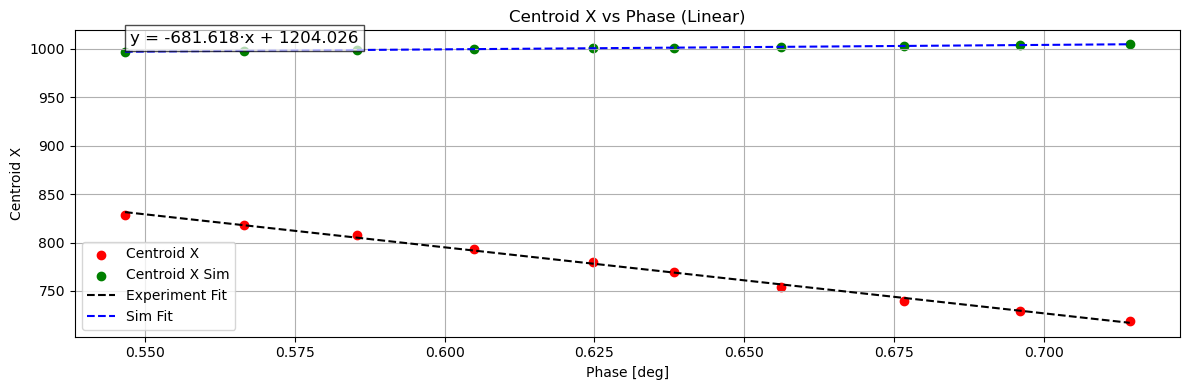

In [14]:


fig, axes = plt.subplots( figsize=(12, 4))

# Centroid X (Linear)
axes.scatter(X, Y[:, 0], color='red', label='Centroid X')
axes.scatter(X,interpolated2, color= 'green', label = 'Centroid X Sim')
axes.plot(X, fit_x, color='black', linestyle='--', label='Experiment Fit')
axes.plot(X, fit_x_sim, color='blue', linestyle='--', label='Sim Fit')
axes.set_title('Centroid X vs Phase (Linear)')
axes.set_xlabel('Phase [deg]')
axes.set_ylabel('Centroid X')
axes.legend()
axes.grid(True)
# Suppose params_x = [m, b]
eqn_x = f"y = {params_x[0]:.3f}·x + {params_x[1]:.3f}"
axes.text(0.05, 0.95, eqn_x, transform=axes.transAxes,
             fontsize=12, verticalalignment='bottom', bbox=dict(facecolor='white', alpha=0.7))


plt.tight_layout()
plt.show()

In [15]:
voltage_in_MV = epics.caget('TCAV:DIAG0:11:AREQ', use_monitor=False)
print(f'before {voltage_in_MV}')
voltage_in_MV = voltage_in_MV + .01
epics.caput('TCAV:DIAG0:11:AREQ', voltage_in_MV)
voltage_in_MV = epics.caget('TCAV:DIAG0:11:AREQ', use_monitor=False)
print(f'after {voltage_in_MV}')

before 0.35
after 0.36


In [16]:
# how is the amplitude related to the slope of the curve? 
def train(num_steps:int, target_beam_parameters: epics.PV, lr = .0001) -> dict:
    # working in single case for now.
    beam_parameter_history = []
    loss_history = []
    amplitude = epics.caget('TCAV:DIAG0:11:AREQ', use_monitor=False)


In [ ]:
recImg = RecursiveImageProjectionFit(visualize=False)
screen = create_screen('DIAG0', 'OTRDG02')
tcav = create_tcav('DIAG0','TCXDG0')
tcav.amp_set = 0.0
#TODO: submit lclstools pr tcav. 
centroid_zerod = screen.image
result = recImg.fit_image(centroid_zerod)
zero_point = result.centroid

In [ ]:
tcav.amp_set = .135
centroid_nominal = screen.image
result_nom = recImg.fit_image(centroid_nominal)
nominal_point = result_nom.centroid

In [19]:
print(f"nominal {nominal_point}")
print(f"zero'd {zero_point}")
cent_x = zero_point[0]

#nominal [np.float64(1004.7178445383822), np.float64(736.4506846286199)]
#zero'd [np.float64(971.9258468438095), np.float64(736.448910940515)]

nominal [np.float64(984.6883137555915), np.float64(736.0263196639239)]
zero'd [np.float64(972.0097615398585), np.float64(736.028843299721)]


In [ ]:
from xopt.vocs import VOCS
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import UpperConfidenceBoundGenerator
from xopt import Xopt

vocs = VOCS(
    variables={"phase": [-180, 180]},
    objectives={"f": "MINIMIZE"},
)
# want minimize the distance between zero_point value created by phase
def phase_scan(input_dict):
    tcav.phase_set = input_dict["phase"]
    print(tcav.phase_set)
    image = screen.image
    result = recImg.fit_image(image)
    cent_x_scan = result.centroid[0]
    value = (cent_x - cent_x_scan)**2
    return {"f": value}
# Take sqrt of value
evaluator = Evaluator(function=phase_scan)
generator = UpperConfidenceBoundGenerator(vocs=vocs)
generator.gp_constructor.use_low_noise_prior = True
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

In [26]:
# call X.random_evaluate() to generate + evaluate 3 initial points
#X.random_evaluate(2)
X.evaluate_data({'phase':np.linspace(-180,180,10)})
# inspect the gathered data
X.data

phase setter working
0.7143632420718454


/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/epics/ca.py:1631: UserWarning: ca.get('OTRS:DIAG0:420:Image:ArrayData') timed out after 1.00 seconds.
  warnings.warn(msg % (name(chid), timeout))


phase setter working
0.7143632420718454
phase setter working
0.7143632420718454
phase setter working
0.7143632420718454
phase setter working
0.7143632420718454
phase setter working
0.7143632420718454
phase setter working
0.7143632420718454
phase setter working
0.7143632420718454
phase setter working
0.7143632420718454
phase setter working
0.7143632420718454


XoptError: Xopt evaluator caught exception(s):

Evaluation index 0:
Traceback (most recent call last):
  File "/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/xopt/utils.py", line 137, in safe_call
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/vz/n3kzmhb11kl0lb9jv7prt8r9gymfby/T/ipykernel_92235/652553259.py", line 14, in phase_scan
    image = screen.image
            ^^^^^^^^^^^^
  File "/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/pydantic/main.py", line 888, in __getattr__
    return super().__getattribute__(item)  # Raises AttributeError if appropriate
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cgarnier/Desktop/sim/lcls-tools/lcls_tools/common/devices/screen.py", line 78, in image
    return self.controls_information.PVs.image.get(as_numpy=True).reshape(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'reshape'

Evaluation index 1:
nan
Evaluation index 2:
Traceback (most recent call last):
  File "/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/xopt/utils.py", line 137, in safe_call
    result = func(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/vz/n3kzmhb11kl0lb9jv7prt8r9gymfby/T/ipykernel_92235/652553259.py", line 14, in phase_scan
    image = screen.image
            ^^^^^^^^^^^^
  File "/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/pydantic/main.py", line 888, in __getattr__
    return super().__getattribute__(item)  # Raises AttributeError if appropriate
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/cgarnier/Desktop/sim/lcls-tools/lcls_tools/common/devices/screen.py", line 78, in image
    return self.controls_information.PVs.image.get(as_numpy=True).reshape(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'reshape'

Evaluation index 3:
nan
Evaluation index 4:
nan
Evaluation index 5:
nan
Evaluation index 6:
nan
Evaluation index 7:
nan
Evaluation index 8:
nan
Evaluation index 9:
nan


phase setter working
0.7143632420718454


/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/epics/ca.py:1631: UserWarning: ca.get('OTRS:DIAG0:420:Image:ArrayData') timed out after 1.00 seconds.
  warnings.warn(msg % (name(chid), timeout))


phase setter working
0.7143632420718454


/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/epics/ca.py:1631: UserWarning: ca.get('OTRS:DIAG0:420:Image:ArrayData') timed out after 1.00 seconds.
  warnings.warn(msg % (name(chid), timeout))


phase setter working
0.7143632420718454


/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/epics/ca.py:1631: UserWarning: ca.get('OTRS:DIAG0:420:Image:ArrayData') timed out after 1.00 seconds.
  warnings.warn(msg % (name(chid), timeout))


phase setter working
0.7143632420718454


/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/epics/ca.py:1631: UserWarning: ca.get('OTRS:DIAG0:420:Image:ArrayData') timed out after 1.00 seconds.
  warnings.warn(msg % (name(chid), timeout))


phase setter working
0.7143632420718454


/Users/cgarnier/anaconda3/envs/linac-simulation/lib/python3.11/site-packages/epics/ca.py:1631: UserWarning: ca.get('OTRS:DIAG0:420:Image:ArrayData') timed out after 1.00 seconds.
  warnings.warn(msg % (name(chid), timeout))


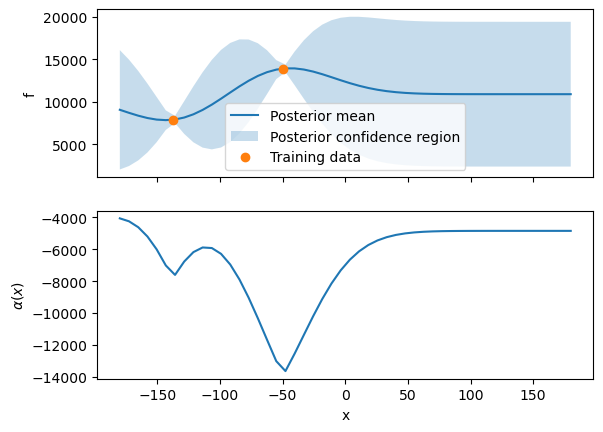

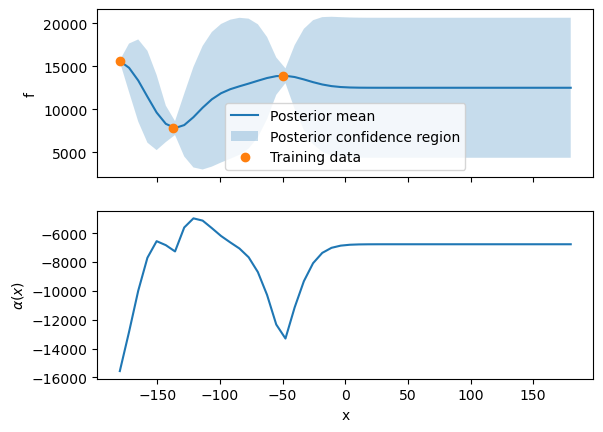

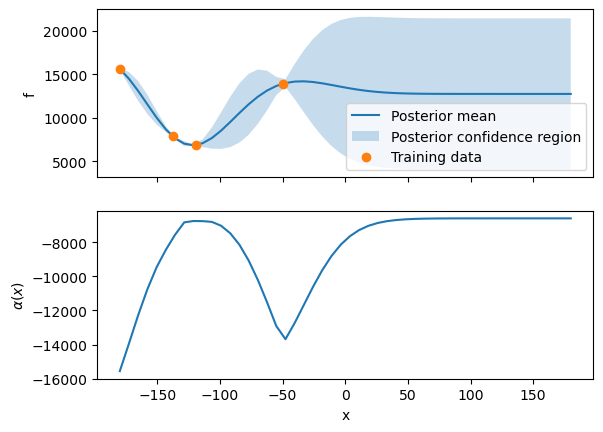

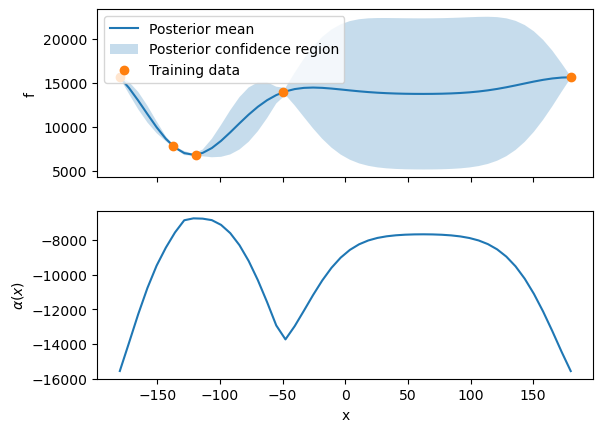

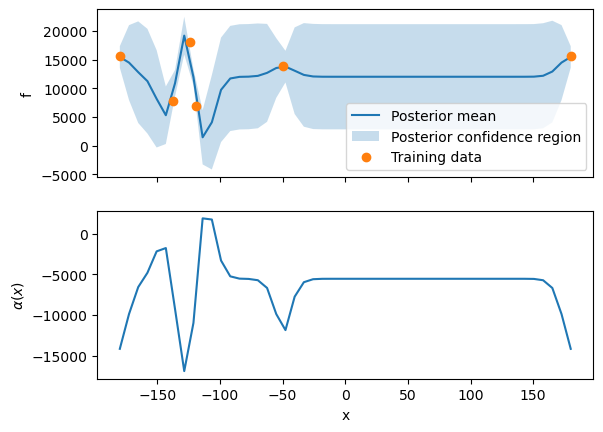

In [22]:
n_steps = 5

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(), 50).double()

for i in range(n_steps):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1, 1, 1))

    # get mean function and confidence regions
    mean = posterior.mean
    L, u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig, ax = plt.subplots(2, 1, sharex="all")

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, L, u, alpha=0.25, label="Posterior confidence region")

    # add data to model plot
    ax[0].plot(X.data["phase"], X.data["f"], "C1o", label="Training data")

    '''
    # plot true function
    true_f = sin_function({"x": test_x})["f"]
    ax[0].plot(test_x, true_f, "--", label="Ground truth")
    '''
    # add legend
    ax[0].legend()

    # plot acquisition function
    ax[1].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("f")
    ax[1].set_ylabel(r"$\alpha(x)$")
    ax[1].set_xlabel("x")

    # do the optimization step
    X.step()

In [ ]:
X.data


,phase,f,xopt_runtime,xopt_error
0,-49.809156,13920.216139,1.854166,False
1,-137.886268,7876.111335,1.808015,False
2,-180.000000,15621.467924,1.786528,False
3,-119.541841,6847.265781,1.800731,False
4,180.000000,15625.430492,1.815879,False
5,-123.627333,18139.398130,1.785592,False
6,-110.614045,4618.445041,1.802300,False


In [24]:
X.data.scatter(x='phase', y ='f')

AttributeError: 'DataFrame' object has no attribute 'scatter'